# Homework 4b Submission
## Yonadav Shavit

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.special import factorial
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.
### (a)
#### i.
$GS_f = \infty$ because the sensitivity is unbounded and so a single point can arbitrarily change the mean.
#### ii.
$\min _{x \in \mathcal{S}} \operatorname{LS}_{f}(x) = \infty$ for the same reasons as above - regardless of any of the other points (i.e. $x$ s.t. we get minimum local sensitivity), a single additional point can arbitrarily change the resulting mean. (For example, to increase the mean by $k$, the new point should be $\mu_{old} + nk$.)
#### iii.
$\mathrm{RS}_{f}^{\mathcal{H}} = \frac{b-a}{n}$ because a single point can change only by $b-a$ while remaining in $H$, and so the average can only change by that divided by $n$.
#### iv.
We can construct an explicit Lipschitz extension by simply clipping each point to $[a, b]$ and then taking the mean and adding Laplace noise with sensitivity $\frac{b-a}{n\epsilon}$. This will be increasingly biased as the original data is farther from $[a, b]$, but the sensitivity will remain the same, and on $H$ this agrees with $f$.

### (b)
#### i.
$GS_f = \infty$ because, for any large $N$, we can construct a dataset with $\frac{n}{2}$ data points at $0$, and $\frac{n}{2}$ datapoints at $N$, and then shifting a single point from $0$ to $N$ shifts the median by $N$, for any arbitrary $N$.
#### ii.
$\min _{x \in \mathcal{S}} \operatorname{LS}_{f}(x) = 0$ because if we create a dataset with $3$ points at $0$, no matter how much we change any single point, the other two will still be $0$ and so the median will be unchanged.
#### iii.
$\mathrm{RS}_{f}^{\mathcal{H}} = b-a$ because every point must fall in $[a, b]$, and so the largest possible change in median would be from $a$ to $b$. (This example is possible if half the points minus 1 are at $a$, and the other half are at $b$, and then we move one from $b$ to $a$).

### (c)
#### i.
$GS_f = n-1$ because if every node was previously disconnected (meaning the value was $n-1$) we can connect a new node to every old node, meaning that now $0$ nodes are disconnected.
#### ii.
$\min _{x \in \mathcal{S}} \operatorname{LS}_{f}(x) = 1$ because if every node in the graph is already connected, the addition of a new node cannot disconnect any existing nodes. The most it can do is add a node with no edges. (Note that our definition of node sensitivity in this case is a little weird, because if we're talking about deleting nodes rather than adding, the minimum local sensitivity is actually $0$, if all edges exist between all nodes.)
#### iii.
$\mathrm{RS}_{f}^{\mathcal{H}} = d$ because the greatest change from adding a single node would be that all existing nodes are unconnected, and then a single new node is added that connects to $d$ other nodes. 
(It can't connect to more than that because it must be in $H$). 
Thus the query can only decrease by $d$.

## 2.

Below is the R code, reproduced. I'm porting it into Python.

In [16]:
def nll(w, b, x, y):
    pi = 1/(1 + np.exp(-b - w*x.reshape(-1)))
    llik = y*np.log(pi + 1e-9) + (1-y)*np.log(1e-9 + 1-pi)
    return - llik

In [96]:
def gaussianReleaseNoise(sensitivity, epsilon, delta, size=1):
    scale = sensitivity*np.sqrt(2*np.log(1.25/delta))/epsilon
    noise = np.random.normal(scale=scale, size=size)
    return noise

In [147]:
PUMSdata = pd.read_csv("../data/MaPUMS5full.csv")
Xpums = (PUMSdata['educ'].values).reshape(-1, 1)
Ypums = PUMSdata['married'].values
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter("default")
lr = LogisticRegression(C=10000).fit(Xpums, Ypums)

print(f"slope = {lr.coef_[0]}, bias = {lr.intercept_}")
print(f"likelihood = {nll(lr.coef_[0], lr.intercept_, Xpums, Ypums).mean()}")
w_true = lr.coef_[0][0]
b_true = lr.intercept_[0]

/home/yonadav/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


slope = [0.07828201], bias = [-0.61997557]
likelihood = 0.6821270958807131


In [148]:
def calc_clipped_gradient(X, Y, C, w, b, fun=nll):
    dx = 1e-4
    out1 = fun(w     , b     , X, Y)
    out2 = fun(w     , b + dx, X, Y)
    out3 = fun(w + dx, b     , X, Y)
    dw = (out3 - out1)/dx
    db = (out2 - out1)/dx
    dw = np.clip(dw, -C, C)
    db = np.clip(db, -C, C)
    return dw, db

In [188]:
def learn_private_regression(epsilon, X_, Y_, delta=1e-6):
    n = Y_.shape[0]
    batchsize = int(np.sqrt(n))
    steps = int(np.sqrt(n))

    idxs = np.random.permutation(n)
    X = X_[idxs, :]
    Y = Y_[idxs]

    w = 0; b = 0         # starting parameters
    C = 10               # clipping parameter
    nu_w, nu_b = .0001, .0001  # learning rates

    w_history = [w]
    b_history = [b]
    
    for i in range(steps):
        batch_start = i*batchsize
        batch_end = min((i + 1)*batchsize, n)
        Xbatch = X[batch_start:batch_end, :]
        Ybatch = Y[batch_start:batch_end]
        dw_clipped, db_clipped = calc_clipped_gradient(Xbatch, Ybatch, C, w, b, fun=nll)
        dw_private = dw_clipped + gaussianReleaseNoise(
            sensitivity=2*C, # one sample can shift from -C to C, so double sensitivity
            epsilon=epsilon/(2*(batchsize*steps)/n), # two parameters released, so halve the epsilon for each
            delta=delta,
            size=batchsize,
        )
        db_private = db_clipped  + gaussianReleaseNoise(
            sensitivity=2*C, # one sample can shift from -C to C, so double sensitivity
            # for each row (constituting its own dataset) we have batchsize*steps/n queries, so spread epsilon
            # for that mini-dataset evenly over queries
            # two parameters released, so halve the epsilon for each
            epsilon=epsilon/(2*(batchsize*steps)/n), 
            delta=delta,
            size=batchsize,
        )
    
        dw_private = dw_private.mean(axis=0)
        db_private = db_private.mean(axis=0)
        # update via calculated gradients
        w -= nu_w*dw_private
        b -= nu_b*db_private
        w_history.append(w)
        b_history.append(b)
        if False:
            print(f"w: {w}, b:{b}")
            print(f"Likelihood: {nll(w, b, X, Y).mean()}")
    return w_history, b_history

In [212]:
X, Y = Xpums, Ypums
w_history, b_history = learn_private_regression(.1, X, Y)
w_final, b_final = w_history[-1], b_history[-1]
print(f"w_final: {w_final}, b_final:{b_final}")
print(f"Likelihood: {nll(w_final, b_final, X, Y).mean()}")

w_final: -0.0906537763390688, b_final:0.10519959855920695
Likelihood: 0.8401312585551419


In [213]:
def accuracy(w, b, X, Y):
    Yhat = 1/(1 + np.exp(-b -w*X.reshape(-1)))
    Yhat = Yhat > 0.5
    return (Yhat == Y).mean()

In [246]:
X, Y = Xpums, Ypums
trials = 100
learned_ws = []
learned_bs = []
mean_accs = []
epsilons = np.logspace(-3, 1, 20)
for eps in tqdm_notebook(epsilons):
    ws = []
    bs = []
    accs = 0
    for t in range(trials):
        wh, bh = learn_private_regression(eps, X, Y)
        ws.append(wh[-1])
        bs.append(bh[-1])
        accs += accuracy(wh[-1], bh[-1], X, Y)
    mean_accs.append(accs/trials)
    learned_ws.append(ws)
    learned_bs.append(bs)

Text(0.5, 0, 'epsilon')

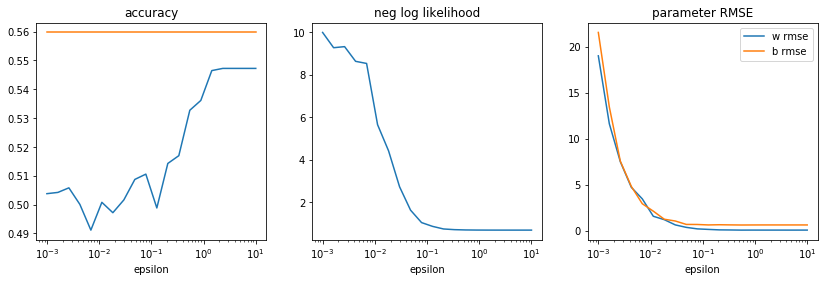

In [248]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.title("accuracy")
plt.plot(epsilons, mean_accs)
plt.plot(epsilons, np.ones(epsilons.shape)*accuracy(w_true, b_true, X, Y))
plt.xlabel("epsilon")
plt.xscale("log")

plt.subplot(1, 3, 3)
plt.title("parameter RMSE")
w_rmses = [np.sqrt(((w_true - np.array(lws))**2).mean(axis=0)) for lws in learned_ws]
b_rmses = [np.sqrt(((b_true - np.array(lbs))**2).mean(axis=0)) for lbs in learned_bs]
plt.plot(epsilons, w_rmses, label="w rmse")
plt.plot(epsilons, b_rmses, label="b rmse")
plt.xscale("log")
plt.legend()
plt.xlabel("epsilon")

plt.subplot(1, 3, 2)
plt.title("neg log likelihood")
liks = [np.mean([nll(ws[i], bs[i], X, Y) for i in range(trials)]) for ws, bs in zip(learned_ws, learned_bs)]
plt.plot(epsilons, liks)
plt.xscale("log")
plt.xlabel("epsilon")

As epsilon increases, as we might expect, the accuracy, loss, and learned parameters converge to the true learned parameters.